## Import

In [23]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
sys.path.insert(1, '../utils')
from utils.df_utils import df_wrapper
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [24]:
AMOUNT_OF_SENSORS = 3
VALIDATION_TESTSET = "004"

### Train

In [25]:
x_train_arr = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    x_train_arr.append(elem)

x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in x_train_arr])
y_train = pd.concat([x.df['Pose'] for x in x_train_arr])

..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

### Test

In [26]:
x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    elem = df_wrapper(testing_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test = elem.df["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    x_test_dict[key] = elem.df
    y_test_dict[key] = y_test

x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]

..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## Visualisation

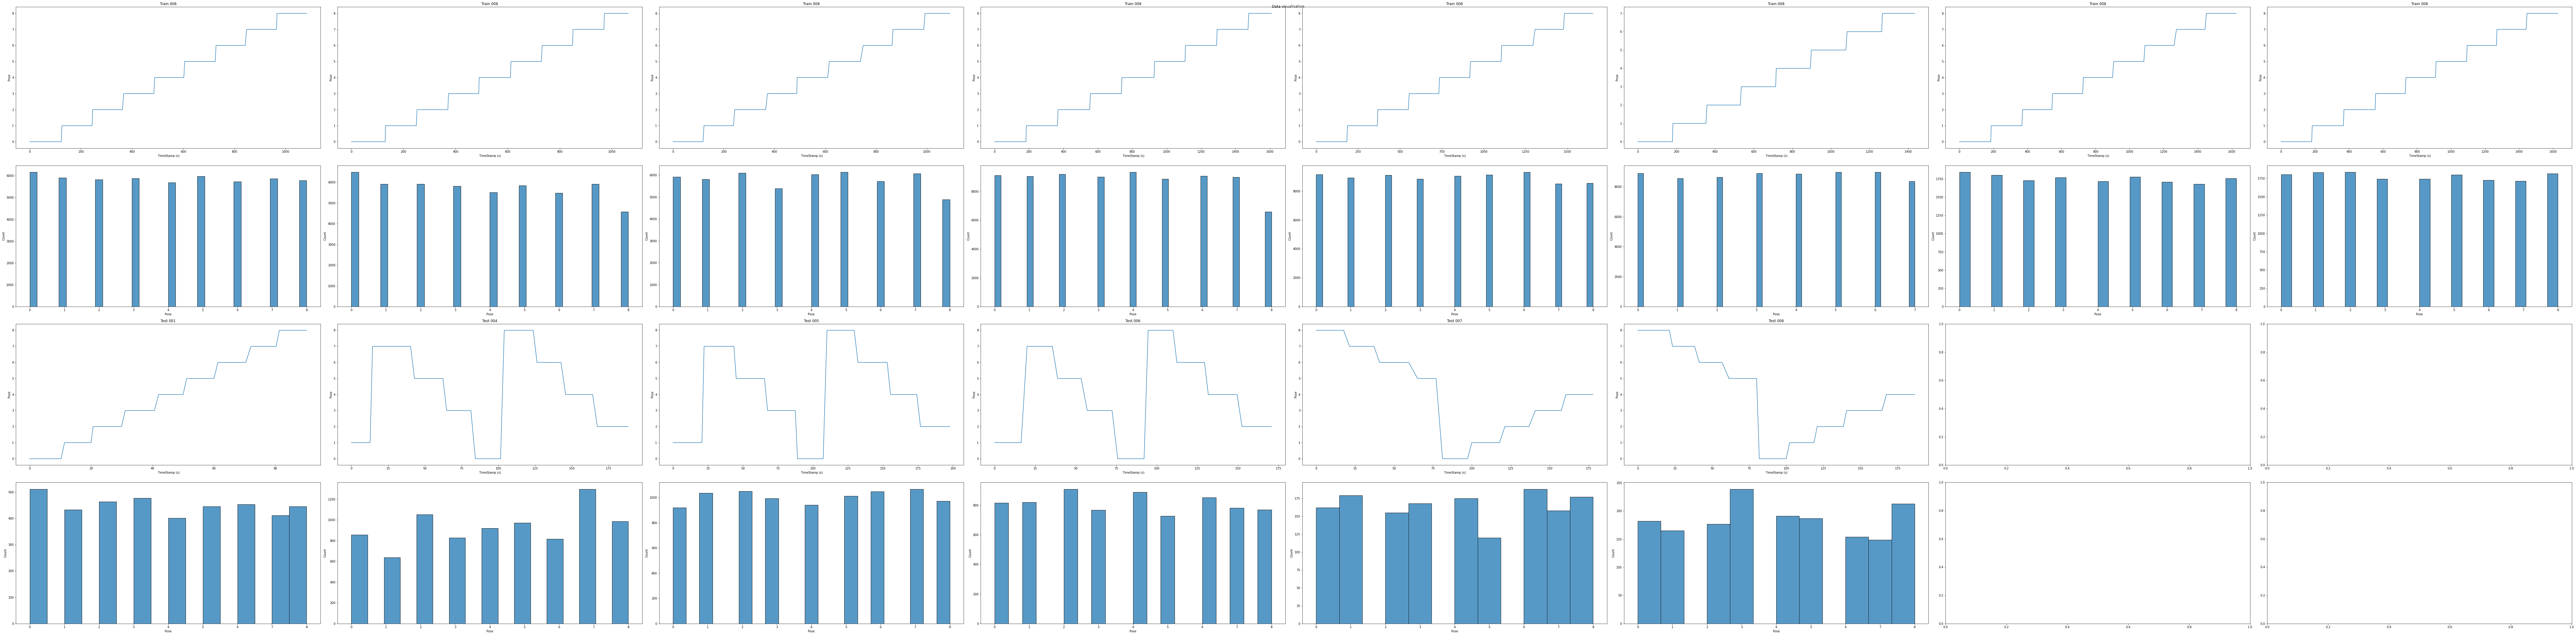

In [27]:
cols = []
height=30
width=(height/2)*len(x_train_arr)
fig, axes = plt.subplots(4, len(x_train_arr), figsize=(width, height))
fig.suptitle('Data visualisation')
# Train
for i, elem in enumerate(x_train_arr):
    sns.lineplot(ax=axes[0, i], data=elem.df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=elem.df["Pose"])
    cols.append(f'Train {key}')    
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
# Test
cols=[]
for i, key in enumerate(x_test_dict):
    sns.lineplot(ax=axes[2, i], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[3, i], data=y_test_dict[key])
    cols.append(f'Test {key}') 
for ax, col in zip(axes[2], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

In [28]:
# Create numpy arrays
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

# Hot encode categories into numbers
y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)

In [29]:
print(x_train_numpy.shape)
print(y_train_numpy.shape)
print(x_test_numpy.shape)
print(y_test_numpy.shape)

(418127, 39)
(418127,)
(8367, 39)
(8367,)


## Adjust dataframes

## Add scaler

In [30]:

from scipy import stats

NUM_TIMESTAMPS = 20

def create_3d_array(array, num_timestamps):

    arr_3d = []
    temp_2d = []
    for i in range(1,len(array)):
        temp_2d.append(array[0])
        if i % NUM_TIMESTAMPS == 0:
            arr_3d.append(temp_2d)
            temp_2d = []
    
    return arr_3d

def create_2d_y_array(array, num_timestamps):
    arr_2d_y_train = []
    temp_y_train = []
    mode_arr = []

    for i in range(1,len(array)):
        #temp_2d.append(array[0])
        temp_y_train.append(array[i])
        if i % NUM_TIMESTAMPS == 0:
            mode_arr.append(temp_y_train)

            temp_y_train = []
            #temp_2d = []

    y_train_to_be_encoded = []

    for i in range(len(mode_arr)):
        mode = stats.mode(mode_arr[i])
        y_train_to_be_encoded.append(mode.mode[0])

    #ONE HOT ENCODING
    encoding = []
    for value in y_train_to_be_encoded:
        vector = [0 for _ in range(9)]
        vector[value] = 1
        encoding.append(vector)
    
    return np.array(encoding)




In [31]:

x_train = np.array(create_3d_array(x_train_numpy, NUM_TIMESTAMPS))
y_train = np.array(create_2d_y_array(y_train_numpy, NUM_TIMESTAMPS))
print(np.shape(x_train))
print(np.shape(y_train))

x_test = np.array(create_3d_array(x_test_numpy, NUM_TIMESTAMPS))
y_test = np.array(create_2d_y_array(y_test_numpy, NUM_TIMESTAMPS))
print("y_test: ", np.shape(y_test))
print("x_test: ", np.shape(x_test))

(20906, 20, 39)
(20906, 9)
y_test:  (418, 9)
x_test:  (418, 20, 39)


In [32]:
#scaler = MinMaxScaler()
#scaler.fit(x_train_numpy)
#x_train_numpy = scaler.transform(arr_3d_x_train)
#x_test_numpy = scaler.transform(arr_2d_y_train)
#y_test = to_categorical(y_test_numpy,9)
print(np.shape(y_train))

(20906, 9)


## Hyperparams

In [33]:
EPOCH = 20
BATCH_SIZE = 10000
LR = 0.00005
DROPOUT_RATE1 = 0.4
DROPOUT_RATE2 = 0.4
ACTIVATION1 = 'relu'
ACTIVATION2 = 'softmax'
OPTIM = Adam(learning_rate=LR)
#OPTIM = RMSPROP(learning_rate=LR)

## Model

In [34]:
from keras.layers import LSTM
from tensorflow.keras import layers

model = Sequential()
model.add(layers.LSTM(48, activation='relu', return_sequences=True, input_shape=[x_train.shape[1], x_train.shape[2]]))
model.add(layers.LSTM(48, activation='relu', input_shape=[x_train.shape[1], x_train.shape[2]]))
model.add(Dense(24,activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer=OPTIM, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

## Fit the model

In [35]:

#model.fit(x=np.array(arr_3d_x_train), batch_size=512, y=y_train, shuffle=False, epochs=10)

model.fit(x=x_train, y=y_train, batch_size=20906, epochs=100, shuffle=False)
#model.reset_states()



Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 86.0601 - accuracy: 0.0812
Epoch 2/100
1/1 [==============================] - 4s 4s/step - loss: 84.9424 - accuracy: 0.0812
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 83.7123 - accuracy: 0.0812
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 82.5256 - accuracy: 0.0812
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 81.5454 - accuracy: 0.0812
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 80.5838 - accuracy: 0.0812
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 79.7635 - accuracy: 0.0812
Epoch 8/100
1/1 [==============================] - 3s 3s/step - loss: 78.9392 - accuracy: 0.0812
Epoch 9/100
1/1 [==============================] - 4s 4s/step - loss: 78.2226 - accuracy: 0.0812
Epoch 10/100
1/1 [==============================] - 4s 4s/step - loss: 77.5153 - accuracy: 0.0812
Epoch 11/100
1/1 [===========

In [36]:
model.evaluate(x_test,y_test, batch_size=1)

418/418 [==============================] - 2s 3ms/step - loss: 227.5713 - accuracy: 0.1029


[227.57130432128906, 0.10287081450223923]

## Visualise the loss

In [37]:
history = pd.DataFrame(model.history.history)
history.plot()

TypeError: no numeric data to plot

## Predict

In [ ]:
predictions = model.predict(x_test_numpy)
predictions_final = []  
y_test_arr = []
for index in range(len(predictions)):
    predictions_final.append(predictions[index].argmax())
    y_test_arr.append(y_test[index].argmax())

number_of_corrects = 0
for i in range(len(predictions_final)):
    if(predictions_final[i] == y_test_arr[i]):
        number_of_corrects += 1
print(number_of_corrects)
print("% of corrects: {}".format(number_of_corrects/len(predictions_final)*100))

7550
% of corrects: 90.23544878690092


## Visualise prediction

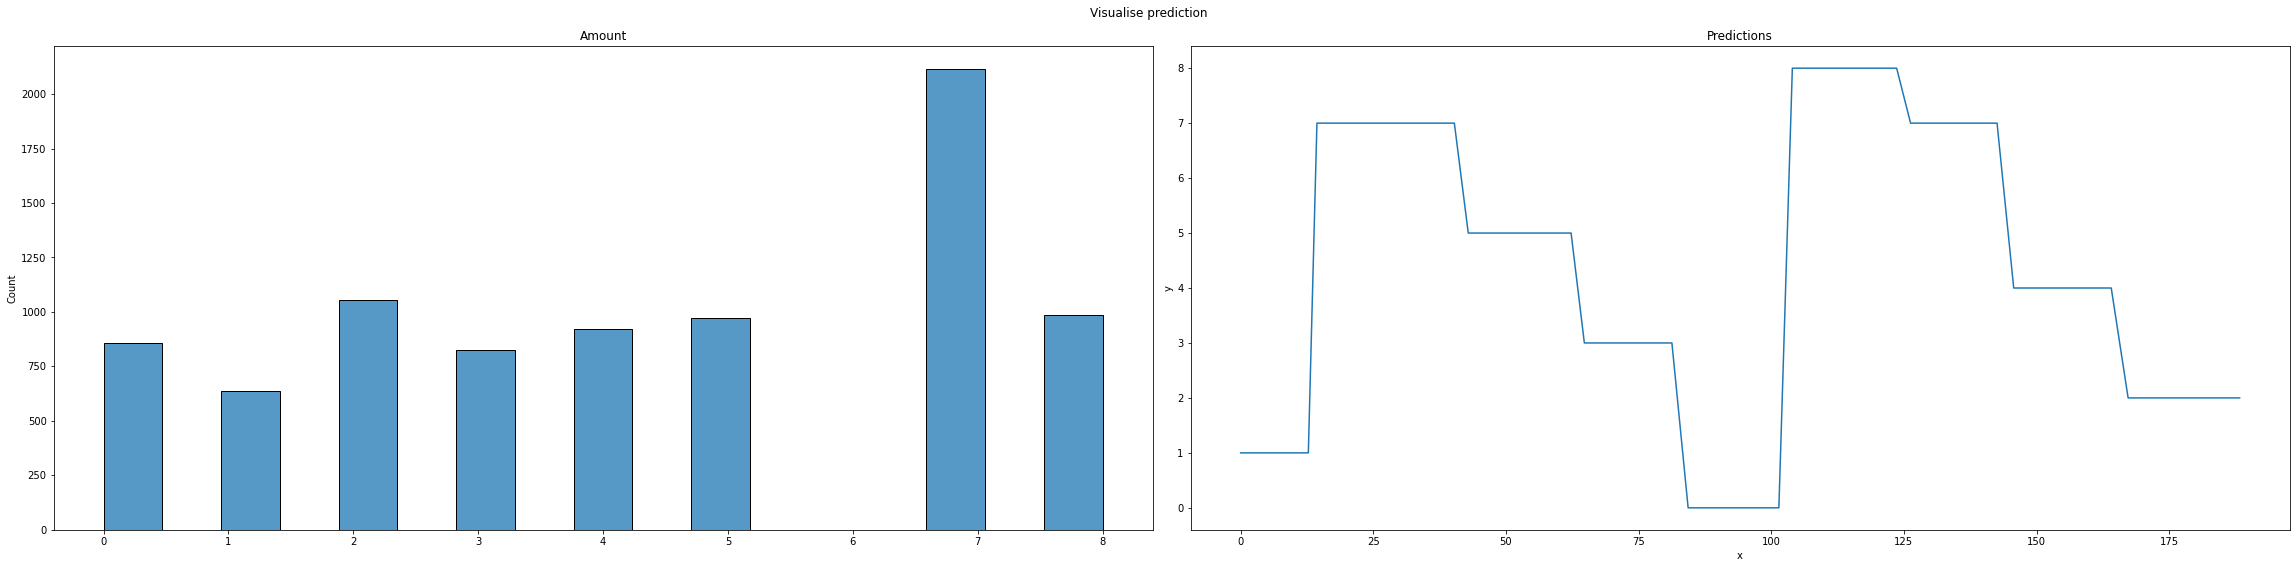

In [ ]:
df_predict = pd.DataFrame({'x': knn_test.df[' TimeStamp (s)'],'y':predictions_final})

fig, axes = plt.subplots(1, 2, figsize=(width, height))
sns.histplot(ax=axes[0], data=predictions_final)
sns.lineplot(ax=axes[1], data=df_predict,x='x',y='y')
fig.suptitle('Visualise prediction')
cols = ['Amount', 'Predictions']
for ax, col in zip(axes, cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

In [ ]:
model.save(f"../models/LSTM_model_{AMOUNT_OF_SENSORS}.h5")

INFO:tensorflow:Assets written to: ../../ANN_model/assets


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>